In [0]:
path = ""
from google.colab import drive, files
drive.mount('/content/drive/')
path = '/content/drive/My Drive/App/Covid19' #"/content/drive/My Drive/App/HPA/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import pandas as pd

import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten,Lambda
from keras.applications.resnet_v2 import ResNet50V2
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
#f1_score, precision_recall_curve, roc_curve,roc_auc_score,average_precision_score,classification_report

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import os, pathlib
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = np.load ('/content/drive/My Drive/App/Covid19/dataset/data.npy')
labels = np.load ('/content/drive/My Drive/App/Covid19/dataset/labels.npy')

(x_train, x_test, y_train, y_test) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

del data
del labels

In [0]:
num_classes = 4 #Normal; Bacterial; Viral; COVID-19
batch_size = 8
epochs = 25
lr = 0.00002 
checkpoint = ''
outputPath = '/content/drive/My Drive/App/Covid19/CovidOutput/'
runID = 'covid-lr' + str(lr)
runPath = outputPath + runID
pathlib.Path(runPath).mkdir(parents=True, exist_ok=True)
dropweight_rate = 0.5
T = 50

In [0]:
def get_callbacks(runPath):
    callbacks = []
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=25, min_lr=0.000001, min_delta=1e-2)
    callbacks.append(lr_schedule) # reduce learning rate when stuck

    checkpoint_path = runPath + '/cp-{epoch:02d}-{val_loss:.2f}_P0.5.h5'
    callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_path,
        verbose=1, save_best_only=True, mode='min', period=1))

    class SaveAsCKPT(keras.callbacks.Callback):
        def __init__(self):
            self.saver = tf.train.Saver()
            self.sess = keras.backend.get_session()

        def on_epoch_end(self, epoch, logs=None):
            checkpoint_path = runPath + '/cp-{:02d}.ckpt'.format(epoch)
            save_path = self.saver.save(self.sess, checkpoint_path)
    callbacks.append(SaveAsCKPT())
    return callbacks

In [0]:
def DropWeights(x):
    import tensorflow as tf
    p = dropweight_rate
    return tf.nn.dropout(x, rate = p) * (1 - p)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Lambda(DropWeights)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
opt = Adam(lr=lr, amsgrad=True)
callbacks = get_callbacks(runPath)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_name = '/content/drive/My Drive/App/Covid19/CovidOutput/covid19_P' + str(dropweight_rate) +'.h5'

datagen = ImageDataGenerator(rotation_range=15, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=[0.8,1.2],
                             fill_mode='nearest',
                             cval=0., 
                             horizontal_flip=True, 
                             vertical_flip=False)

datagen.fit(x_train)

class_weight = {0: 2.,
                1: 2.,
                2: 1.,
                3: 50.}

# Fit the model on the batches generated by datagen.flow().
'''
model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    callbacks=callbacks,
                    epochs=epochs,
                    class_weight=class_weight,
                    validation_data=(x_test, y_test))
'''
#model.fit(x_train, y_train, batch_size=batch_size, callbacks=callbacks, epochs=epochs, class_weight=class_weight, validation_data=(x_test, y_test))


'\nmodel.fit_generator(datagen.flow(x_train, y_train,\n                                 batch_size=batch_size),\n                    callbacks=callbacks,\n                    epochs=epochs,\n                    class_weight=class_weight,\n                    validation_data=(x_test, y_test))\n'

In [0]:
from keras.models import load_model
dropweight_rate = 0.5
#model = load_model ("/content/drive/My Drive/App/Covid19/CovidOutput/covid-lr2e-05/cp-01-1.32_P0.5.h5",custom_objects={'dropweight_rate': dropweight_rate})
model = load_model ("/content/drive/My Drive/App/Covid19/output/pneu-lr2e-05/cp-02-0.54_P0.5.h5",custom_objects={'dropweight_rate': dropweight_rate})


In [0]:
y_pred_standard = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_standard.argmax(axis=1))
cm_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
class_acc = np.array(cm_norm.diagonal())
print('Normal: {0:.3f}, Bacterial: {1:.3f}, Viral: {2:.3f}, COVID-19: {3:.3f}'.format(class_acc[0],
                                                                                      class_acc[1],
                                                                                      class_acc[2],
                                                                                      class_acc[3]))


Normal: 0.943, Bacterial: 0.889, Viral: 0.429, COVID-19: 1.000


Text(30.5, 0.5, 'Actual')

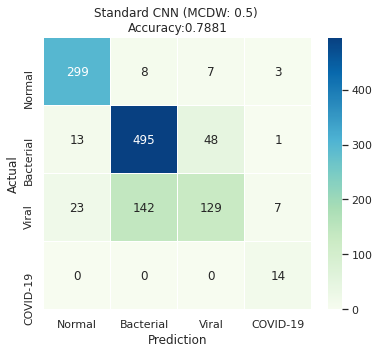

In [0]:
cm = np.array(matrix)
sns.set()
acc_std = accuracy_score(y_test.argmax(axis=1), y_pred_standard.argmax(axis=1))

cm_df = pd.DataFrame(cm,                     
                     index = ["Normal", "Bacterial", "Viral","COVID-19"], 
                     columns = ["Normal", "Bacterial", "Viral","COVID-19"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,cmap="GnBu",linewidths=.3,fmt="d")
plt.title('Standard CNN (MCDW: ' + str(dropweight_rate) + ') \nAccuracy:{0:.4f}'.format(acc_std))
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [0]:
p_hat = []
for t in range(T):
    p_hat.append(model.predict(x_test,verbose=0))
MC_samples = np.array(p_hat)

In [0]:
y_pred_bayesian = np.mean(MC_samples, axis=0)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_bayesian.argmax(axis=1))
cm_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
class_acc = np.array(cm_norm.diagonal())
print(class_acc)
print('Normal: {0:.3f}, Bacterial: {1:.3f}, Viral: {2:.3f}, COVID-19: {3:.3f}'.format(class_acc[0],
                                                                                      class_acc[1],
                                                                                      class_acc[2],
                                                                                      class_acc[3]))

[[302   8   5   2]
 [ 15 497  43   2]
 [ 22 132 143   4]
 [  0   0   0  14]]
[0.95268139 0.89228007 0.47508306 1.        ]
Normal: 0.953, Bacterial: 0.892, Viral: 0.475, COVID-19: 1.000


Text(30.5, 0.5, 'Actual')

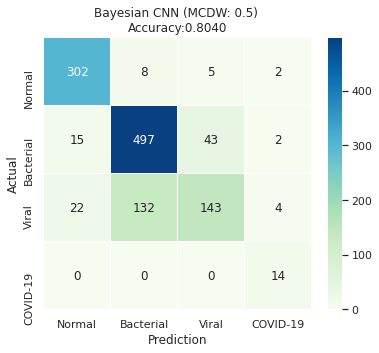

In [0]:
cm = np.array(matrix)
acc_bayes = accuracy_score(y_test.argmax(axis=1), y_pred_bayesian.argmax(axis=1))
sns.set()
cm_df = pd.DataFrame(cm,                     
                     index = ["Normal", "Bacterial", "Viral","COVID-19"], 
                     columns = ["Normal", "Bacterial", "Viral","COVID-19"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True,cmap="GnBu",linewidths=.3,fmt="d")
plt.title('Bayesian CNN (MCDW: ' + str(dropweight_rate) + ') \nAccuracy:{0:.4f}'.format(acc_bayes))
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [0]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def categorical_entropy(proba):
    return - np.sum(proba * np.log(proba + 1e-20), axis=-1)

def predictive_entropy(MC_samples):
    """
    Entropy of the probabilities (to measure the epistemic uncertainty)
    :param prob: probabilities of shape [batch_size, C]
    :return: Entropy of shape [batch_size]
    """
    eps = 1e-5
    prob = np.mean(MC_samples, axis=0)
    return -1 * np.sum(np.log(prob+eps) * prob, axis=1)

def bias_corrected_uncertainty(MC_samples):
    proba = np.copy(MC_samples) 

    # plug-in estimate of entropy    
    proba_avg = proba.mean(axis=0)
    entropy_expected = categorical_entropy(proba_avg)

    # jackknife correction
    proba_loo = proba_avg + (proba_avg - proba) / (len(proba) - 1)
    expected_entropy_loo = categorical_entropy(proba_loo).mean(axis=0)
    entropy_expected += (len(proba) - 1) * (entropy_expected - expected_entropy_loo)

    BCU = entropy_expected - categorical_entropy(proba).mean(axis=0)
    return BCU

def BALD(MC_samples):
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy
    return BALD_acq

H = predictive_entropy(MC_samples)
#H = BALD(MC_samples)
#H = bias_corrected_uncertainty(MC_samples)

# Let's normalize the uncertainty values (in range [0, 1])
H_norm = (H - H.min()) / (H.max() - H.min())


In [0]:
predIdxs = model.predict(x_test, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

MC_samples = np.array(p_hat)
mean_prob = np.mean(MC_samples, axis=0) 
y_pred = np.argmax(mean_prob,axis=1) 

acc_reg = 1 - np.count_nonzero(np.not_equal(predIdxs, y_test.argmax(axis=1))) / mean_prob.shape[0]
acc_mc = 1 - np.count_nonzero(np.not_equal(mean_prob.argmax(axis=1), y_test.argmax(axis=1))) / mean_prob.shape[0]

print('Accuracy of Standart CNN = {:.02%}'.format(acc_reg))
print('Accuracy of Bayesian CNN = {:.02%}'.format(acc_mc))

Accuracy of Standart CNN = 79.14%
Accuracy of Bayesian CNN = 80.40%


(1189, 4) (1189,)


Text(0.5, 1.0, 'Predictive posterior')

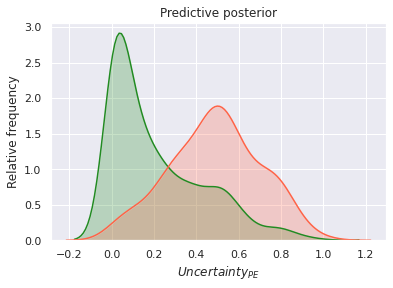

In [0]:
sns.set()
#Uncertainty of correct/incorrect predictions
print(y_test.shape,y_pred.shape)
sns.kdeplot(H_norm[y_test.argmax(axis=1) == y_pred], shade=True, color='forestgreen')
sns.kdeplot(H_norm[y_test.argmax(axis=1) != y_pred], shade=True, color='tomato')
plt.xlabel('$ Uncertainty_{PE} $')
plt.ylabel('Relative frequency') #(r'rel. frequency')
plt.title('Predictive posterior')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


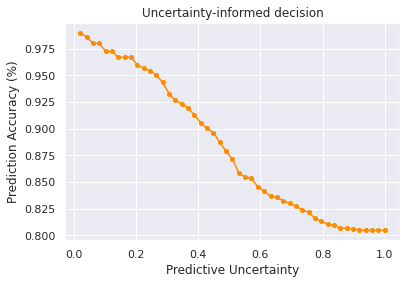

In [0]:
#Accuracy as a function of tolerated uncertainty
def normalized_uncertainty_toleration_removal(y, y_pred, y_var, num_points, save=False, save_dir=''):
    acc_uncertainty, acc_overall = np.array([]), np.array([])
    num_cls = len(np.unique(y))
    y_var = (y_var - y_var.min()) / (y_var.max() - y_var.min())
    per_class_remain_count = np.zeros((num_points, num_cls))
    per_class_acc = np.zeros((num_points, num_cls))
    thresholds = np.linspace(0, 1, num_points)
    remain_samples = []
    for i, t in enumerate(thresholds):
        idx = np.argwhere(y_var >= t)
        y_temp = np.delete(y, idx)
        remain_samples.append(len(y_temp))
        y_pred_temp = np.delete(y_pred, idx)
        acc_uncertainty = np.append(acc_uncertainty, np.sum(y_temp == y_pred_temp) / y_temp.shape[0])
        if len(y_temp):
            per_class_remain_count[i, :] = np.array([len(y_temp[y_temp == c]) for c in range(num_cls)])
            per_class_acc[i, :] = np.array(
                [np.sum(y_temp[y_temp == c] == y_pred_temp[y_temp == c]) / y_temp[y_temp == c].shape[0] for c in
                 range(num_cls)])

    plt.figure()
   
    sns.set()
    plt.plot(thresholds, acc_uncertainty, lw=1.5, color='darkorange', marker='o', markersize=4)
    plt.title('Uncertainty-informed decision')
    plt.xlabel('Predictive Uncertainty')
    plt.ylabel('Prediction Accuracy (%)')
    
num_intervals = 50
normalized_uncertainty_toleration_removal(y_test.argmax(axis=1), y_pred, H_norm, num_intervals)


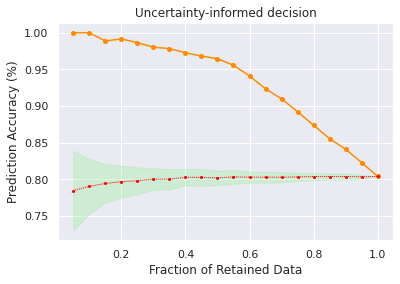

In [0]:
#Accuracy as a function of fraction of referrals
def uncertainty_fraction_removal(y, y_pred, y_var, num_fracs, num_random_reps, save=False, save_dir=''):
    fractions = np.linspace(1 / num_fracs, 1, num_fracs)
    num_samples = y.shape[0]
    acc_unc_sort = np.array([])
    acc_pred_sort = np.array([])
    acc_random_frac = np.zeros((0, num_fracs))
    acc_unc_frac = np.zeros((0, num_fracs))

    remain_samples = []
    # uncertainty-based removal
    inds = y_var.argsort()
    y_sorted = y[inds]
    y_pred_sorted = y_pred[inds]
    for frac in fractions:
        y_temp = y_sorted[:int(num_samples * frac)]
        remain_samples.append(len(y_temp))
        y_pred_temp = y_pred_sorted[:int(num_samples * frac)]
        acc_unc_sort = np.append(acc_unc_sort, np.sum(y_temp == y_pred_temp) / y_temp.shape[0])
    
    acc_unc_frac = np.concatenate((acc_unc_frac, np.reshape(acc_unc_sort, [1, -1])), axis=0)
    acc_unc_m = np.mean(acc_unc_frac, axis=0)
    acc_unc_s = np.std(acc_unc_frac, axis=0)
    
    # random removal
    for rep in range(num_random_reps):
        acc_random_sort = np.array([])
        perm = np.random.permutation(y_var.shape[0])
        y_sorted = y[perm]
        y_pred_sorted = y_pred[perm]
        for frac in fractions:
            y_temp = y_sorted[:int(num_samples * frac)]
            y_pred_temp = y_pred_sorted[:int(num_samples * frac)]
            acc_random_sort = np.append(acc_random_sort, np.sum(y_temp == y_pred_temp) / y_temp.shape[0])
        acc_random_frac = np.concatenate((acc_random_frac, np.reshape(acc_random_sort, [1, -1])), axis=0)
    acc_random_m = np.mean(acc_random_frac, axis=0)
    acc_random_s = np.std(acc_random_frac, axis=0)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    line2, = ax.plot(fractions, acc_unc_sort, 'o-', lw=1.5, label='uncertainty-based', markersize=4, color='darkorange')    
    
    line1, = ax.plot(fractions, acc_random_m, 'o', lw=1, label='Random', markersize=2, color='red')
    ax.fill_between(fractions,
                    acc_random_m - acc_random_s,
                    acc_random_m + acc_random_s,
                    color='lightgreen', alpha=0.3)
    line1.set_dashes([1, 1, 1, 1])  # 2pt line, 2pt break, 10pt line, 2pt break
   
    sns.set()
    ax.set_title('Uncertainty-informed decision')
    ax.set_xlabel('Fraction of Retained Data')
    ax.set_ylabel('Prediction Accuracy (%)')
   
reps_for_random = 40
num_fractions = 20
uncertainty_fraction_removal(y_test.argmax(axis=1), y_pred, H_norm, num_fractions, reps_for_random)

In [0]:
correct_output_cat = np.copy(y_test) 
bcu = predictive_entropy (MC_samples)
bld = BALD (MC_samples)
mc_output_mean = np.mean(MC_samples, axis=0)
MC_samples = MC_samples.reshape(MC_samples.shape[1],MC_samples.shape[0],4)

In [0]:
u_bcu = []
u_bald = []

bcu = (bcu - bcu.min()) / (bcu.max() - bcu.min())
bld = (bld - bld.min()) / (bld.max() - bld.min())
i = 0
for o, c in zip(MC_samples, correct_output_cat):
    o_m = o.mean(axis=0)
    u_bald.append(bld[i])
    u_bcu.append(bcu[i])
    i = i+1

u_bald_np = np.array(u_bald)
u_bcu_np = np.array(u_bcu)

In [0]:
# calculate correlation
import scipy.stats as stats
from keras.utils import to_categorical

eps = 1e-16
kld = []

for mc, c in zip(mc_output_mean, correct_output_cat):
    kld.append(stats.wasserstein_distance(mc, c))
   
kld_np = np.array(kld)

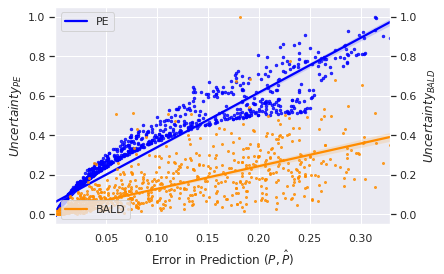

In [0]:
sns.set()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax2 = ax1.twinx()

stride = 1

ax1.set_xlabel(r"Error in Prediction $ ( P , \hat{P} ) $")
ax1.set_ylabel(r"$ Uncertainty_{PE} $")
sns.regplot(x=kld_np[::stride], y=u_bcu_np[::stride], ax=ax1, color='blue', scatter_kws={'s':6}, line_kws={'label':"PE"})
ax1.legend()

ax2.set_ylabel(r"$ Uncertainty_{BALD} $")
sns.regplot(x=kld_np[::stride], y=u_bald_np[::stride], ax=ax2, color='darkorange', scatter_kws={'s':4}, line_kws={'label':"BALD"})
ax2.grid(False, axis='y')
ax2.legend()

ylim = ax2.get_ylim()
xlim = ax1.get_xlim()
plt.legend(loc="lower left")
plt.show()

In [0]:
# calculate correlation coefficient

print(stats.spearmanr(kld_np, u_bcu_np))
print(stats.spearmanr(kld_np, u_bald_np))

SpearmanrResult(correlation=0.9929944717902963, pvalue=0.0)
SpearmanrResult(correlation=0.9210992111501685, pvalue=0.0)


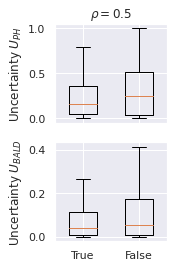

In [0]:
correct_u_bcu = []
incorrect_u_bcu = []
correct_u_bald = []
incorrect_u_bald = []

bcu = (bcu - bcu.min()) / (bcu.max() - bcu.min())

bld = (bld - bld.min()) / (bld.max() - bld.min())

i = 0
for o, c in zip(MC_samples, correct_output_cat):
    o_m = o.mean(axis=0)
    
    if o_m.argmax() == c.argmax():
        correct_u_bald.append(bld[i])
        correct_u_bcu.append(bcu[i])        
    else:
        incorrect_u_bald.append(bld[i])
        incorrect_u_bcu.append(bcu[i])
    i =i +1

correct_u_bcu_np = np.array(correct_u_bcu)
incorrect_u_bcu_np = np.array(incorrect_u_bcu)
correct_u_bald_np = np.array(correct_u_bald)
incorrect_u_bald_np = np.array(incorrect_u_bald)

box_width = 0.5
fig, axs = plt.subplots(2, 1, figsize=(2, 4), sharex='col', sharey='row')

axs[0].boxplot([correct_u_bcu_np, incorrect_u_bcu_np], sym="+", widths=box_width, showfliers=False)
axs[0].set_title(r"$ \rho =" + str(dropweight_rate) +" $")
axs[0].set_ylabel(r"Uncertainty $ U_{PH} $")
axs[0].set_xticklabels([r'True', r'False'])

axs[1].boxplot([correct_u_bald_np, incorrect_u_bald_np], sym="+", widths=box_width, showfliers=False)
axs[1].set_ylabel(r"Uncertainty $ U_{BALD} $")
axs[1].set_xticklabels([r'True', r'False'])
fig.align_ylabels(axs)